In [1]:
import tensorflow as tf
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split

Switching ON tensorflow resource usage logs

In [6]:
# tf.debugging.set_log_device_placement(True)
# print('Num of GPU is', len(tf.config.list_physical_devices('GPU')))

## Data Loading

In [7]:
data_frame = pd.read_csv('../data/data_collected_v1.csv', names=['signal1'])

data_frame.head()

,signal1
0,0.000000
1,0.000000
2,0.005000
3,0.010000
4,0.014999


### Dummy multi signal dataframe

In [8]:
signal2 = data_frame.to_numpy().flatten()
signal3 = data_frame.to_numpy().flatten()

In [9]:
data_frame['signal2'] = signal2
data_frame['signal3'] = signal3

In [10]:
data_frame.describe()

,signal1,signal2,signal3
count,1602.000000,1602.000000,1602.000000
mean,0.143317,0.143317,0.143317
std,0.698879,0.698879,0.698879
min,-0.999997,-0.999997,-0.999997
25%,-0.538244,-0.538244,-0.538244
50%,0.281921,0.281921,0.281921
75%,0.814438,0.814438,0.814438
max,1.000000,1.000000,1.000000


## Plot data

<AxesSubplot: >

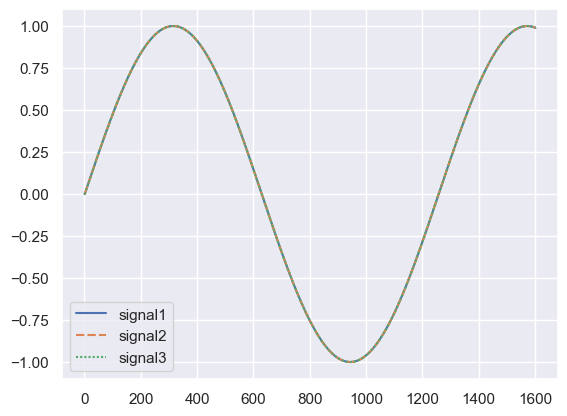

In [11]:
sns.set_theme(style="darkgrid")

#Plot the responses for different events and regions
sns.lineplot(data=data_frame)

In [12]:
train_test_val_split = (0.8, 0.1, 0.1)
train_df = data_frame[:int(len(data_frame)*train_test_val_split[0])]
test_df = data_frame[int(len(data_frame)*train_test_val_split[0]):int(len(data_frame)*(train_test_val_split[0]+train_test_val_split[1]))]
val_df = data_frame[int(len(data_frame)*(train_test_val_split[0]+train_test_val_split[1])):]

## Normalization of data

[TODO] The model shouldn't have access to future values in the training set when training, and hence normalization should be done using moving averages.

But now we are considering simple average

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
train_df

,signal1,signal2,signal3
0,-0.001454,-0.001454,-0.001454
1,-0.001454,-0.001454,-0.001454
2,0.005682,0.005682,0.005682
3,0.012818,0.012818,0.012818
4,0.019953,0.019953,0.019953
...,...,...,...
1276,0.129399,0.129399,0.129399
1277,0.136503,0.136503,0.136503
1278,0.143604,0.143604,0.143604
1279,0.150701,0.150701,0.150701


## Window generator

In [15]:
train_df['signal1'].to_numpy().flatten()

array([-0.00145364, -0.00145364,  0.00568227, ...,  0.14360416,
        0.1507013 ,  0.15779464])

### Creating single signal dataset

In [16]:
uni_train_ds = tf.data.Dataset.from_tensor_slices((train_df['signal1'].to_numpy().flatten()))
uni_single_test_ds = tf.data.Dataset.from_tensor_slices((test_df['signal1'].to_numpy().flatten()))
uni_single_val_ds = tf.data.Dataset.from_tensor_slices((val_df['signal1'].to_numpy().flatten()))

In [17]:
for features in uni_train_ds.take(2):
  print(f'{features.numpy()}')

-0.0014536359342466397
-0.0014536359342466397


### Windowing signal dataset
Here tensorflow's batch pipeline is used to window

In [18]:
feature_length = 10
label_length = 3

features = uni_train_ds.batch(feature_length, drop_remainder=True)
labels = uni_train_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(2):
  print(f'{features.numpy()}, " => ", {label.numpy()}')

[-0.00145364 -0.00145364  0.00568227  0.01281801  0.01995338  0.02708822
  0.03422235  0.04135558  0.04848775  0.05561866], " => ", [0.06274815 0.06987604 0.07700214]
[0.06274815 0.06987604 0.07700214 0.08412628 0.09124828 0.09836796
 0.10548515 0.11259966 0.11971132 0.12681996], " => ", [0.13392538 0.14102742 0.1481259 ]


### Defining generic window generator class

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.column_indices}',
        f'Selected column name(s): {self.label_columns}',
        ])
  # def get_feature_label(self, features, labels):
  #   feature_length = 10
  #   label_length = 3

  #   features = train_ds.batch(feature_length, drop_remainder=True)
  #   labels = train_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

  #   predicted_steps = tf.data.Dataset.zip((features, labels))
  #   return features, labels

In [20]:
w1 = WindowGenerator(input_width=24, label_width=24, shift=24,
                     label_columns=['signal1'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): {'signal1': 0, 'signal2': 1, 'signal3': 2}
Selected column name(s): ['signal1']

### Splitting window helper method
Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

__Note:__ The below parameter of WindowGenerator class controls the window specs:
1. label_columns - No. of features are needed (in our case it is signals)
2. input_width - No. of timesteps needed as input feature for each batch
3. label_width - No. of timesteps needed as target vector for each batch

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['signal1', 'signal2', 'signal3'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): {'signal1': 0, 'signal2': 1, 'signal3': 2}
Selected column name(s): ['signal1', 'signal2', 'signal3']

In [23]:
train_df[:w2.total_window_size]

,signal1,signal2,signal3
0,-0.001454,-0.001454,-0.001454
1,-0.001454,-0.001454,-0.001454
2,0.005682,0.005682,0.005682
3,0.012818,0.012818,0.012818
4,0.019953,0.019953,0.019953
5,0.027088,0.027088,0.027088
6,0.034222,0.034222,0.034222


In [24]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 3)


### Ploting
Here we are adding a plotter method to the WindowGenerator so that we can visualize it better.
This method will plot the example sample which is a property of this class (can be set any sample using example property of this class)

E.g., WindowGenerator.example = example_inputs, example_labels

In [25]:
w2.example = example_inputs, example_labels

In [26]:
def plot(self, model=None, plot_col='signal1', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

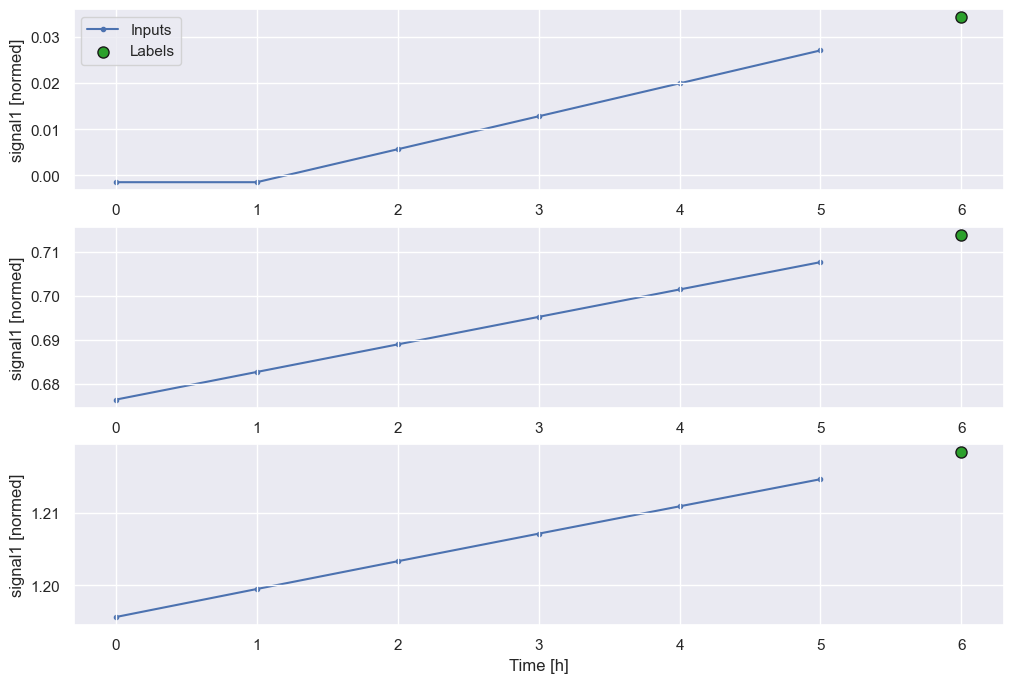

In [27]:
w2.plot()

Here we can see that there are 6 time steps input for each batch (each row = one batch) and there is one timestep target value

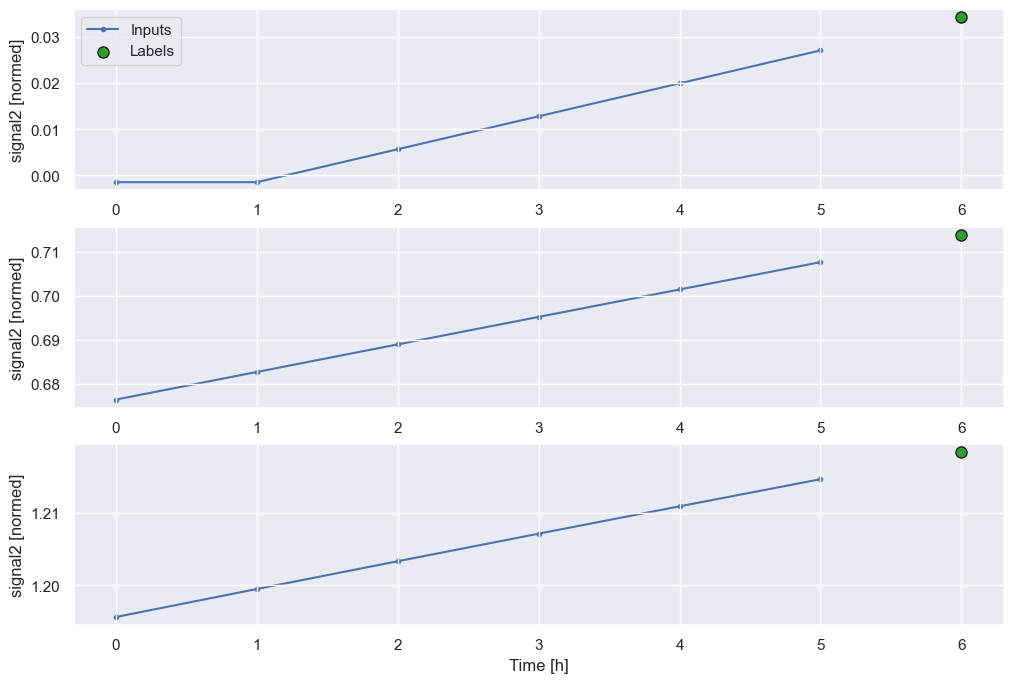

In [28]:
w2.plot(plot_col='signal2')

## Dataset

Here we generate dataset with batches of (input_window, label_window) pairs

In [29]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Lets put train, test, validation dataset in one place. The most convinient is to attach as property to WindowGenerator class

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test


We add one batch to example property that we described earlier 

In [31]:
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.example = example

In [32]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None))

In [33]:
for sample_inputs, sample_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {sample_inputs.shape}')
  print(f'Labels shape (batch, time, features): {sample_labels.shape}')
  # print(f'elements: {sample_inputs}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 3)


In [34]:
w2.train

<MapDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None))>

## Example dataset creating
In this section we mention some example on how dataset can be generated using WindowGenerator class we created in previous section

### Single step window
one timestep input and target

In [35]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['signal1'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): {'signal1': 0, 'signal2': 1, 'signal3': 2}
Selected column name(s): ['signal1']

### Multistep step window
Multi timestep input and target

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['signal1'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): {'signal1': 0, 'signal2': 1, 'signal3': 2}
Selected column name(s): ['signal1']

Directly pass the `train`, `val` and `test` property of `WindowGenerator` to the `model.fit` method.

__E.g,.__: model.fit(wide_window.train, epochs=MAX_EPOCHS,
                      validation_data=wide_window.val)

In [37]:
for i in wide_window.train.take(1):
    print(i)

(<tf.Tensor: shape=(32, 24, 3), dtype=float32, numpy=
array([[[-0.6836884 , -0.6836884 , -0.6836884 ],
        [-0.68994766, -0.68994766, -0.68994766],
        [-0.6961897 , -0.6961897 , -0.6961897 ],
        ...,
        [-0.8113135 , -0.8113135 , -0.8113135 ],
        [-0.81717914, -0.81717914, -0.81717914],
        [-0.82302433, -0.82302433, -0.82302433]],

       [[ 0.97658217,  0.97658217,  0.97658217],
        [ 0.9817668 ,  0.9817668 ,  0.9817668 ],
        [ 0.9869269 ,  0.9869269 ,  0.9869269 ],
        ...,
        [ 1.0801302 ,  1.0801302 ,  1.0801302 ],
        [ 1.0847725 ,  1.0847725 ,  1.0847725 ],
        [ 1.0893875 ,  1.0893875 ,  1.0893875 ]],

       [[-1.4276443 , -1.4276443 , -1.4276443 ],
        [-1.4278932 , -1.4278932 , -1.4278932 ],
        [-1.4281064 , -1.4281064 , -1.4281064 ],
        ...,
        [-1.425381  , -1.425381  , -1.425381  ],
        [-1.424881  , -1.424881  , -1.424881  ],
        [-1.4243455 , -1.4243455 , -1.4243455 ]],

       ...,

      

In [38]:
# df = pd.DataFrame(train_df['signal1'].rolling(5).mean())
# df.head()

: 